# Задача
В архиве во вложении данные по выдачам кредитов и платежам: плановым и фактическим. Данные актуальны на 08.12.2022. Проанализируйте характер поведения клиентов с точки зрения просрочки: какая динамика просрочки, наблюдается ли рост или снижение?

# Столбцы
order_id – номер заявки<br>
created_at - дата создания заявки<br>
put_at - дата выдачи<br>
closed_at - дата закрытия<br>
issued_sum - сумма выдачи<br>
plan_at - дата планового платежа<br>
plan_sum_total - сумма планового платежа (накопленным итогом)<br>
paid_at - дата фактического платежа<br>
paid_sum - сумма фактического платежа<br>


# Определения

**Просрочка**— это нарушение должником сроков и/или объёмов исполнения обязательств, предусмотренных договором (графиком платежей).

Уточним определение, применительно к данному исследованию

**Просрочка по плажету**(далее Просрочка)<br>
Просрочкой по платежу будем называть *недостаток средств* по счету заявки после даты планового платежа. 

**Недостаток средств**<br>
В день плановой даты накопленный итог больше, чем сумма всех платежей. То есть сумма всех платежей не соответствует предъявленным обязательствам на дату.

# Уточнения
* Условия расчета суммы планового платежа не предоставлены, поэтому будем считать, что если заявка закрыта до следующей плановой даты платежом меньше планового, то обязательства по ней считаются исполненными в полной мере. Иначе говоря, для закрытых до планового срока заявок проценты расчитаны корректно и выплачены в полной мере.

* Столбцы с денежными единицами имеют тип данных float, что может вести к ошибкам при вычислениях(знаменитое 0.1 + 0.2 != 0.3). Типы данных библиотеки numpy не предоставляют подходящих вариантов для выражения денежных единиц. Есть два способа решения этой проблемы:
    1. Считать все числа меньше 0.01 за 0
    2. Округлить все числа до двух знаков после запятой, умножить на 100 и перевести в целочиленный тип. В таком случае все незначительные числа(около e-13) будут выражены как 1 или 2. Погрешность составит менее 10 копеек.

    Задача не уточняет допустимую погрешность в денежных суммах, поэтому во избежание лишних допущений выбран первый способ. Для второго просто представлен код конвертации

# Обработка таблиц и данных



## Библиотеки

In [42]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Обзор таблиц

In [43]:
data_dir = Path.cwd() / 'task_2_data'
dfs = {str(data_file.stem): pd.read_csv(data_file) for data_file in data_dir.iterdir()}

In [44]:
for name in dfs: 
    print('\n' + '*' * 10 + name.upper() + '*' * 10)
    print(dfs[name].head())
    print()
    print(dfs[name].info())


**********ORDERS**********
    order_id               created_at                   put_at  \
0  400001732  2022-06-02 00:00:23.997  2022-06-02 20:18:00.180   
1  400005838  2022-06-02 00:10:22.997  2022-06-02 15:41:33.267   
2  400007915  2022-06-02 00:18:04.000  2022-06-05 19:17:38.547   
3  400008952  2022-06-02 00:22:07.000  2022-06-03 14:25:18.033   
4  400009027  2022-06-02 00:25:39.000  2022-06-02 00:40:40.320   

                 closed_at  issued_sum  
0  2022-10-17 11:52:22.190     13600.0  
1  2022-06-02 17:38:43.917     20000.0  
2  2022-06-21 21:55:51.877      5820.0  
3  2022-07-12 10:47:46.307      9000.0  
4  2022-06-22 14:15:07.423      5000.0  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55748 entries, 0 to 55747
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    55748 non-null  int64  
 1   created_at  55748 non-null  object 
 2   put_at      55748 non-null  object 
 3   closed_at 

В таблице orders лишь уникальные order_id

In [45]:
dfs['orders']['order_id'].nunique() == dfs['orders'].shape[0]

True

Для полей с временем установим тип данных datetime

In [46]:
orders = dfs['orders']
payments = dfs['payments']
plan = dfs['plan']
orders[['created_at', 'put_at', 'closed_at']] = orders[['created_at', 'put_at', 'closed_at']].apply(pd.to_datetime)
payments[['paid_at']] = payments[['paid_at']].apply(pd.to_datetime)
plan[['plan_at']] = plan[['plan_at']].apply(pd.to_datetime)

Для полей с денежными значениями избавимся от ошибок плавающей точки, следующим образом:
* округлим до 2го числа после точки
* умножим на 100
* переведем в целочисленный тип

In [47]:
# def to_money_type(x):
#     return round(x, 2) * 100

# orders[['issued_sum']] = orders[['issued_sum']].apply(to_money_type).astype(int)
# payments[['paid_sum']] = payments[['paid_sum']].apply(to_money_type).astype(int)
# plan[['plan_sum_total']] = plan[['plan_sum_total']].apply(to_money_type).astype(int)

## Примеры данных

In [48]:
# Закрыт заранее одним платежом
# order_id = 400005838
# order_id = 400014289

# Закрыт полностью досрочно
# order_id = 400001732

# order_id = 400007915

# Ошибка плавающей точки
# order_id = 400564695

# Много просрочек
# order_id = 400039450

# Источники резкого скачка
# order_id = 414262167
# order_id = 413853839
# order_id = 414201755
# order_id = 413911250
# order_id = 414305554
order_id = 414288881

orders[orders['order_id'] == order_id]

,order_id,created_at,put_at,closed_at,issued_sum
8398,414288881,2022-06-15 21:45:15.997,2022-06-15 21:56:23.453,2022-06-30 19:24:55.020,2000.0


In [49]:
plan[plan['order_id'] == order_id]

,order_id,plan_at,plan_sum_total
61996,414288881,2022-06-30,230000.0


In [50]:
payments[payments['order_id'] == order_id]

,order_id,paid_at,paid_sum
16193,414288881,2022-06-30 19:24:55.020,2300.0


## Исправление ошибок в данных

**В данных была найдена ошибка, описанная в разделе [Общая сумма задолженностей на дату](#общая-сумма-задолженностей-на-дату). Для ее исправления раскомментировать ячейку ниже**

invalid_orders = [414262167, 413853839, 414201755, 413911250, 414305554, 414288881]
for order in invalid_orders:
    value = plan[plan['order_id'] == order]['plan_sum_total']
    plan.loc[plan['order_id'] == order, ['plan_sum_total']] = value / 100
    

# Анализ

In [51]:
df = payments.merge(plan, how='left', on='order_id')
# Оставляем только платежи до каждой из плановой дат
df = df[df['paid_at'].dt.date <= df['plan_at'].dt.date]
# Считаем сумму к плановой дате для каждой заявки
sums_to_date = df.groupby(by=['order_id', 'plan_at'])['paid_sum'].sum()
# Добавляем полученные суммы к основной таблице
df = df.merge(sums_to_date, on=['order_id', 'plan_at']).rename(columns={'paid_sum_y': 'sum_to_date'})
# Считаем разницу между плановой суммой и суммой к дате
df['sum_diff'] = df['plan_sum_total'] - df['sum_to_date']
df

,order_id,paid_at,paid_sum_x,plan_at,plan_sum_total,sum_to_date,sum_diff
0,400013633,2022-06-02 00:48:13.800,2500.00,2022-06-02,2500.00,2500.00,0.000000e+00
1,400013633,2022-06-02 00:48:13.800,2500.00,2022-06-09,3750.00,2500.00,1.250000e+03
2,400013633,2022-06-02 00:48:13.800,2500.00,2022-06-24,5079.13,13715.50,-8.636370e+03
3,400013633,2022-06-02 00:48:13.800,2500.00,2022-07-09,5942.76,13715.50,-7.772740e+03
4,400013633,2022-06-02 00:48:13.800,2500.00,2022-07-24,6806.39,13715.50,-6.909110e+03
...,...,...,...,...,...,...,...
1146084,480026135,2022-12-08 13:25:11.987,1193.25,2023-01-09,17752.05,15415.50,2.336550e+03
1146085,480026135,2022-12-08 13:25:11.987,1193.25,2023-01-24,18895.35,15415.50,3.479850e+03
1146086,480026135,2022-12-08 13:25:11.987,1193.25,2023-02-08,20022.00,15415.50,4.606500e+03
1146087,436374755,2022-12-08 13:28:23.703,381.10,2022-12-11,6323.76,6323.76,-9.094947e-13


In [52]:
# Оставляем лишь один экземпляр плановой даты
sum_diffs = df.groupby(by=['order_id', 'plan_at'], as_index=False)['sum_diff'].agg([('sum_diff', 'last')])
# Нумеруем плановые платежи
sum_diffs['n_payment'] = sum_diffs.groupby(by='order_id').cumcount() + 1
# Оставляем лишь просроченные
sum_diffs = sum_diffs[sum_diffs['sum_diff'] > 0]
# Убираем плановые платежи после даты закрытия зaявки или незакрытые вовсе
sum_diffs = sum_diffs.merge(orders[['order_id', 'closed_at']], how='left', on='order_id')
sum_diffs = sum_diffs[(sum_diffs['plan_at'] <= sum_diffs['closed_at']) | sum_diffs['closed_at'].isna()]
# Убираем платежи, где неуплаченная сумма меньше одной копейки
sum_diffs = sum_diffs[sum_diffs['sum_diff'] > 0.01]
# Добавляем разметку на закрытые и незакрытые на нынешний день (2022-12-08)
sum_diffs['is_closed'] = ~sum_diffs['closed_at'].isna()
sum_diffs

,order_id,plan_at,sum_diff,n_payment,closed_at,is_closed
1,400007915,2022-06-20,910.00,2,2022-06-21 21:55:51.877,True
2,400010534,2022-07-02,2517.67,2,2022-07-14 22:15:19.217,True
3,400013633,2022-06-09,1250.00,2,2022-06-16 03:15:48.960,True
7,400017255,2022-07-09,792.21,4,2022-07-10 23:41:17.397,True
10,400020168,2022-07-17,1925.85,4,2022-10-31 14:15:23.383,True
...,...,...,...,...,...,...
95724,495174013,2023-02-20,14053.89,13,NaT,False
95725,495174505,2022-09-12,1965.00,1,2022-09-16 18:36:09.857,True
95728,495177509,2023-01-21,2577.34,11,NaT,False
95729,495177509,2023-02-05,5117.69,12,NaT,False


## Количество открытых и закрытых заявок

In [53]:
sum_diffs.groupby(by=['is_closed'])['order_id'].nunique()

is_closed
False     7260
True     12729
Name: order_id, dtype: int64

## Количество просрочек по открытым и закрытым заявкам

In [54]:
sum_diffs.groupby(by=['is_closed'])['sum_diff'].count()

is_closed
False    51363
True     24836
Name: sum_diff, dtype: int64

## Неуплаченная сумма по открытым и закрытым заявкам

### Распределение

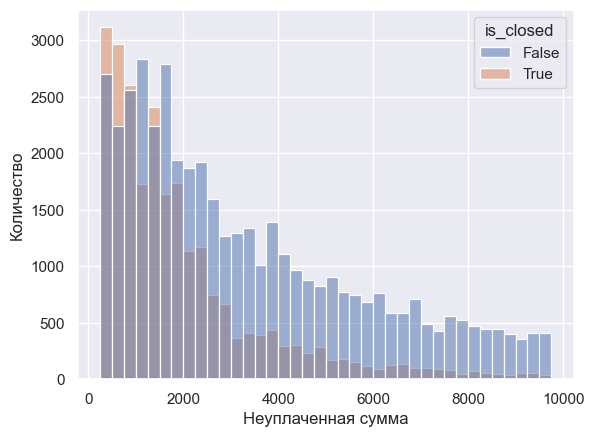

In [55]:
bin_base = 250
bin_count = 40
sns.set_theme('notebook')
ax = sns.histplot(data=sum_diffs, x='sum_diff', bins=list(range(bin_base, bin_base * bin_count, bin_base)), hue='is_closed')
ax.set(xlabel='Неуплаченная сумма', ylabel='Количество')
plt.show()

### Среднее

In [56]:
sum_diffs_closed = sum_diffs[sum_diffs['is_closed']]['sum_diff']
sum_diffs_unclosed = sum_diffs[~sum_diffs['is_closed']]['sum_diff']
print(f'Для закрытых заявок: {sum_diffs_closed.mean()}')
print(f'Для открытых заявок: {sum_diffs_unclosed.mean()}')

Для закрытых заявок: 2345.2933145434044
Для открытых заявок: 5023.765822284524


### Медиана

In [57]:
print(f'Для закрытых заявок: {sum_diffs_closed.median()}')
print(f'Для открытых заявок: {sum_diffs_unclosed.median()}')

Для закрытых заявок: 1425.0
Для открытых заявок: 3341.1799999999994


### Персентили

In [58]:
quantiles = [0.05, 0.25, 0.75, 0.95]
print('Закрытые заявки:')
for quant in quantiles:
    print(f'{quant * 100}%: {sum_diffs_closed.quantile(quant)}')
print('\nОткрытые заявки:')
for quant in quantiles:
    print(f'{quant * 100}%: {sum_diffs_unclosed.quantile(quant)}')

Закрытые заявки:
5.0%: 360.0
25.0%: 784.1075000000001
75.0%: 2535.0
95.0%: 6656.882499999999

Открытые заявки:
5.0%: 470.0
25.0%: 1525.4
75.0%: 6954.665
95.0%: 15223.973999999998


## Какой по счету плановый платеж был просрочен первым

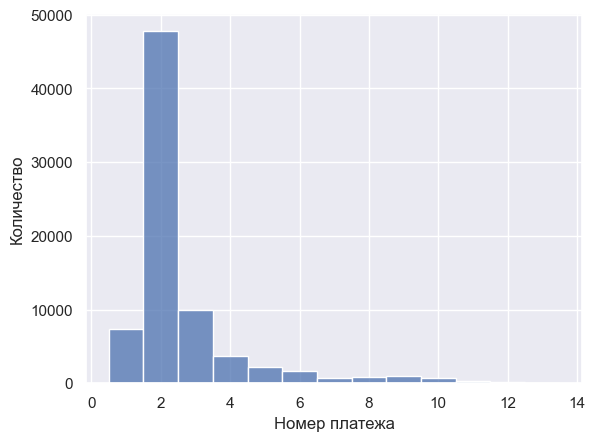

In [59]:
data = sum_diffs.groupby(by='order_id')['n_payment'].transform('first')
ax = sns.histplot(data=data, discrete=True)
ax.set(xlabel='Номер платежа', ylabel='Количество')
plt.show()

In [60]:
sum_diffs

,order_id,plan_at,sum_diff,n_payment,closed_at,is_closed
1,400007915,2022-06-20,910.00,2,2022-06-21 21:55:51.877,True
2,400010534,2022-07-02,2517.67,2,2022-07-14 22:15:19.217,True
3,400013633,2022-06-09,1250.00,2,2022-06-16 03:15:48.960,True
7,400017255,2022-07-09,792.21,4,2022-07-10 23:41:17.397,True
10,400020168,2022-07-17,1925.85,4,2022-10-31 14:15:23.383,True
...,...,...,...,...,...,...
95724,495174013,2023-02-20,14053.89,13,NaT,False
95725,495174505,2022-09-12,1965.00,1,2022-09-16 18:36:09.857,True
95728,495177509,2023-01-21,2577.34,11,NaT,False
95729,495177509,2023-02-05,5117.69,12,NaT,False


## Количество просроченных подряд платежей

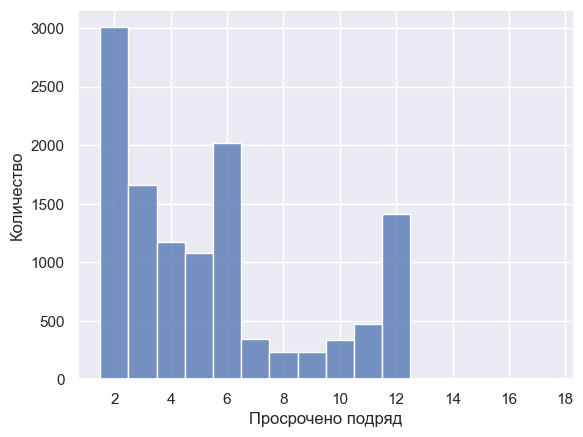

In [61]:
# Считаем количество просроченных платежей для заявки
counts = sum_diffs.groupby(by=['order_id'])['sum_diff'].count()
data = sum_diffs.merge(counts, on='order_id').rename(columns={'sum_diff_y': 'n_debts'})
# Оставляем только те, где больше одного просроченного платежа
data = data[data['n_debts'] > 1]
# Подсчитываем подряд
data['diff'] = data.groupby(by='order_id')['n_payment'].diff()
data = data[data['diff'] == 1]
consecutive_count = data.groupby(by=['order_id'])['diff'].count() + 1

ax = sns.histplot(data=consecutive_count, discrete=1)
ax.set(xlabel='Просрочено подряд', ylabel='Количество')
plt.show()



## Временная динамика

### Количество задолженнстей на дату

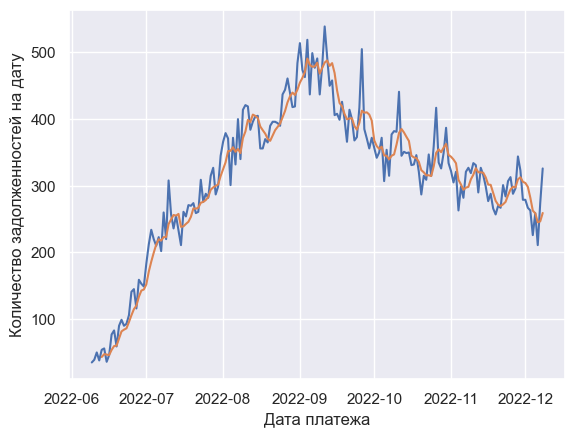

In [62]:
current_date = '2022-12-08'
n_debts_per_date = sum_diffs.groupby(by=['plan_at'])[['order_id']].count().reset_index()
n_debts_per_date = n_debts_per_date[n_debts_per_date['plan_at'] <= pd.to_datetime(current_date)]
n_debts_per_date['rolling_avg'] = n_debts_per_date['order_id'].rolling(window=5).mean()
ax = sns.lineplot(data=n_debts_per_date, x='plan_at', y='order_id')
ax = sns.lineplot(data=n_debts_per_date, x='plan_at', y='rolling_avg', ax=ax)
ax.set(xlabel='Дата платежа', ylabel='Количество задолженностей на дату')
plt.show()

Говоря об общей динамике: явно наблюдается снижение количества задолженностей к актуальной дате (2022-12-08)<br>
Предметами для более подробного исследования могут послужить:
1. Пик в середине полугодичного периода<br>
    Гипотезы для проверки: 
    заем выдается на 3 месяца и существует тендеция гасить сумму в конце одним платежом;
    начало данных является непосредственно точкой отсчета и рост на графике отражает рост базы заявок
2. Периодический характер роста и снижения<br>
    Гипотезы для проверки: 
    таков регламент работы организации: дату выдачи заемов сдвигают к определенным дням для удобства рассчетов;
    естесвенная динамика, поскольку именно в первую и последнию трети месяца людям поступают деньги.
    

### Общая сумма задолженностей на дату

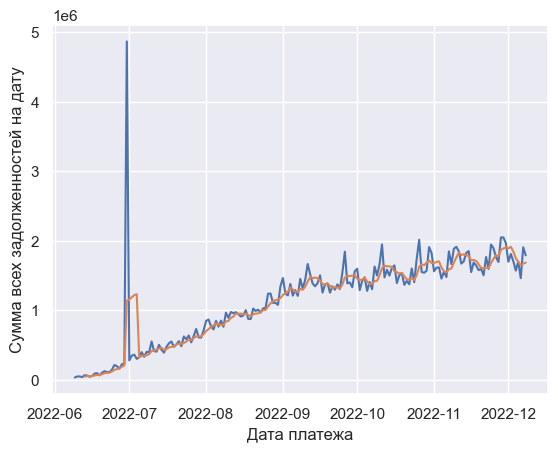

In [63]:
current_date = '2022-12-08'
sum_debts_per_date = sum_diffs.groupby(by=['plan_at'])[['sum_diff']].sum().reset_index()
sum_debts_per_date = sum_debts_per_date[sum_debts_per_date['plan_at'] <= pd.to_datetime(current_date)]
sum_debts_per_date['rolling_avg'] = sum_debts_per_date['sum_diff'].rolling(window=5).mean()
ax = sns.lineplot(data=sum_debts_per_date, x='plan_at', y='sum_diff')
ax = sns.lineplot(data=sum_debts_per_date, x='plan_at', y='rolling_avg', ax=ax)
ax.set(xlabel='Дата платежа', ylabel='Сумма всех задолженностей на дату')
plt.show()

Общая сумма задолженностей безусловно растет. Также можно наблюдать названный ранее периодический характер кривой в правой половине графика.<br>
Причиной резкого скачка является ошибка в данных. Видимо исходные данные были не удачно переведены из денежного типа или наоборот.


### Странный всплеск. Попробуем разобраться.

Ошибка в столбце plan_sum_total по индексам:
* order_id = 414262167
* order_id = 413853839
* order_id = 414201755
* order_id = 413911250
* order_id = 414305554
* order_id = 414288881

In [64]:
max_sum = sum_debts_per_date['sum_diff'].max()
peak_date = sum_debts_per_date[sum_debts_per_date['sum_diff'] == max_sum]['plan_at'].iloc[0]
peak_date

Timestamp('2022-06-30 00:00:00')

In [65]:
sum_diffs[sum_diffs['plan_at'] == peak_date].merge(orders, on='order_id', how='left').merge(plan, on='order_id', how='left').sort_values('plan_sum_total', ascending=False)[['order_id', 'sum_diff', 'issued_sum', 'plan_sum_total']]

,order_id,sum_diff,issued_sum,plan_sum_total
1017,414262167,1252350.00,11000.0,1265000.0
1003,414201755,1024650.00,9000.0,1035000.0
871,413853839,1024650.00,9000.0,1035000.0
911,413911250,683100.00,6000.0,690000.0
1058,414305554,455400.00,4000.0,460000.0
...,...,...,...,...
169,406158051,896.90,2720.0,720.0
117,406035174,907.00,2720.0,720.0
156,406144095,542.96,2720.0,720.0
1358,422167794,360.00,2720.0,720.0
